# LLM Report Generation: Agent Orchestration & Prompting Strategy

This notebook demonstrates:
1. **Agent Orchestration Flow**: How multiple specialized agents work together
2. **Prompting Strategy**: How each agent is prompted
3. **State Management**: How data flows through the workflow


In [1]:
from src.llm.graph import create_report_workflow
from src.llm.state import ReportState
from src.llm import prompts

## 1. Workflow Architecture

The system uses **LangGraph** to orchestrate multiple specialized agents in a sequential workflow.


2025-11-21 16:18:24 | INFO     | src.llm.graph:create_report_workflow:45 - Creating report generation workflow
2025-11-21 16:18:24 | INFO     | src.llm.graph:create_report_workflow:71 - Workflow created successfully


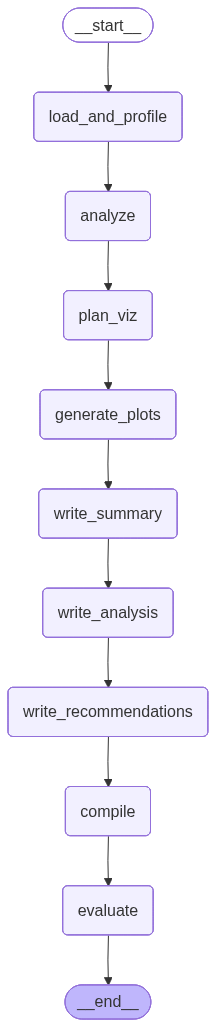

In [2]:
# Create the workflow
workflow = create_report_workflow()

# Display the workflow as a mermaid diagram
try:
    from IPython.display import Image, display

    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception as e:
    # Fallback to text representation
    print("Mermaid diagram generation requires additional dependencies.")
    print(f"Error: {e}")
    print("\nWorkflow Structure:")
    print(workflow.get_graph().draw_ascii())


## 2. Specialized Agents

The system employs **three specialized LLM agents**, each with a unique system prompt.


In [3]:
print("=" * 80)
print("AGENT 1: BUSINESS ANALYST")
print("=" * 80)
print(prompts.SYSTEM_PROMPT_ANALYST)
print("\n" + "=" * 80)
print("AGENT 2: VISUALIZATION EXPERT")
print("=" * 80)
print(prompts.SYSTEM_PROMPT_VISUALIZATION)
print("\n" + "=" * 80)
print("AGENT 3: BUSINESS WRITER")
print("=" * 80)
print(prompts.SYSTEM_PROMPT_WRITER)


AGENT 1: BUSINESS ANALYST
You are an expert business analyst specializing in automotive sales analysis.
You have access to data introspection tools that provide ground truth about the dataset.
Analyze the provided data profile and extract key business insights.
Be precise, data-driven, and focus on actionable findings.
IMPORTANT: Use ONLY the actual column names, values, and statistics provided by the tools.

AGENT 2: VISUALIZATION EXPERT
You are a data visualization expert. Design effective visualizations 
to communicate insights clearly and professionally.
You have access to actual column names and data types from introspection tools.
CRITICAL: Use ONLY the column names provided in the data summary. Do not assume or guess column names.

AGENT 3: BUSINESS WRITER
You are a business report writer. Write clear, concise, and professional 
reports that are understandable to C-level executives.


## 3. Prompting Strategy

### 3.1 Analyst Agent - Data Analysis Prompt


In [4]:
print("ANALYSIS PROMPT TEMPLATE:")
print("=" * 80)
print(prompts.ANALYSIS_PROMPT_TEMPLATE)


ANALYSIS PROMPT TEMPLATE:
Analyze the dataset using the tool-validated information below:

{data_profile}

The above information comes from data introspection tools that have inspected the actual dataset.
Use ONLY the column names, values, and statistics shown above.

Identify:
1. Key trends over time, specifically by year or region (use actual date column detected).
2. Regional performance patterns, highlighting top and underperforming markets (use actual categorical values found).
3. Top and bottom performing models by sales (based on actual values from tools).
4. Key drivers of sales (e.g., price, market segment, or model type)
5. Electrical vehicle (EV, which consists of Electric and Hybrid Fuel Type) market share and trends over the years.
6. Regional market preferences, an example is below: 
Regional Model Preferences
Different markets favor different models:
North America: i8 leads (sporty EV appeal)
Middle East: X6 and M5 (performance/luxury SUVs)
Europe: i8 and M3 (performance

### 3.2 Visualization Expert - Visualization Planning Prompt


In [5]:
print("VISUALIZATION PLANNING PROMPT TEMPLATE:")
print("=" * 80)
print(prompts.VISUALIZATION_PLANNING_PROMPT_TEMPLATE)


VISUALIZATION PLANNING PROMPT TEMPLATE:
Based on these insights:

{insights}

And this data summary (includes ACTUAL column names from data introspection tools):
{statistical_summary}

Plan {min_plots}-{max_plots} informative visualizations.

CRITICAL: The data summary above contains the ACTUAL column names available in the dataset.
Use ONLY these column names. Do not assume columns like 'date', 'sales', 'region' exist unless they are listed above.

Suggested Visualization Types:

1. **Temporal Analysis** (if date column exists):
   - Line chart showing trends over time
   - Use the actual date column name from the tools
   - Aggregate by appropriate time period

2. **Comparative Analysis** (for categorical columns):
   - Bar charts showing top/bottom performers
   - Use actual categorical column names and values from tools
   - Apply aggregation='sum' or 'mean' as appropriate

3. **Relationship Analysis** (for numeric columns):
   - Scatter plots showing relationships between numeric 

### 3.3 Writer Agent - Report Writing Prompts


In [6]:
print("EXECUTIVE SUMMARY PROMPT:")
print("=" * 80)
print(prompts.EXECUTIVE_SUMMARY_PROMPT_TEMPLATE)
print("\n" + "=" * 80)
print("\nRECOMMENDATIONS PROMPT:")
print("=" * 80)
print(prompts.RECOMMENDATIONS_PROMPT_TEMPLATE)


EXECUTIVE SUMMARY PROMPT:
Write an executive summary (2-3 paragraphs) for this BMW sales analysis.

Key Findings:
{key_findings}

Insights:
{insights}

The summary should:
- Be business-focused and actionable
- Highlight the most critical findings
- Be understandable to C-level executives
- Be 200-300 words

Write in markdown format.


RECOMMENDATIONS PROMPT:
Based on this analysis:

Insights: {insights}
Key Findings: {key_findings}

Provide 5-7 actionable business recommendations.

Each recommendation should include:
- The recommendation
- Rationale based on data
- Expected impact
- Priority (High/Medium/Low)

Format as markdown bullet points.


## 4. State Management

LangGraph maintains a **shared state** (`ReportState`) that flows through all nodes.


In [7]:
print("REPORT STATE SCHEMA:")
print("=" * 80)

# Get the state annotations
state_fields = ReportState.__annotations__

categories = {
    "Input": ["data_path", "data"],
    "Data Profiling": ["data_profile", "statistical_summary"],
    "Analysis": ["insights", "trends", "key_findings"],
    "Visualization": ["plot_specs", "plot_paths"],
    "Report Generation": ["executive_summary", "analysis_sections", "recommendations"],
    "Output": ["report_markdown", "report_paths"],
    "Evaluation": ["evaluation_results"],
    "Metadata": ["errors", "step_count"],
}

for category, fields in categories.items():
    print(f"\n{category}:")
    for field in fields:
        if field in state_fields:
            field_type = state_fields[field]
            print(f"  • {field}: {field_type}")


REPORT STATE SCHEMA:

Input:
  • data_path: <class 'str'>
  • data: typing.Optional[typing.Any]

Data Profiling:
  • data_profile: typing.Optional[typing.Dict[str, typing.Any]]
  • statistical_summary: typing.Optional[typing.Dict[str, typing.Any]]

Analysis:
  • insights: typing.Optional[typing.List[typing.Dict[str, str]]]
  • trends: typing.Optional[typing.Dict[str, typing.Any]]
  • key_findings: typing.Optional[typing.List[str]]

Visualization:
  • plot_specs: typing.Optional[typing.List[typing.Dict[str, typing.Any]]]
  • plot_paths: typing.Optional[typing.List[str]]

Report Generation:
  • executive_summary: typing.Optional[str]
  • analysis_sections: typing.Optional[typing.Dict[str, str]]
  • recommendations: typing.Optional[typing.List[str]]

Output:
  • report_markdown: typing.Optional[str]
  • report_paths: typing.Optional[typing.Dict[str, str]]

Evaluation:
  • evaluation_results: typing.Optional[typing.Dict[str, float]]

Metadata:
  • errors: typing.List[str]
  • step_count: <

## 5. Data Introspection Tools

The system uses **6 data introspection tools** that run BEFORE LLM analysis to provide ground truth about the dataset.


In [8]:
from src.llm.tools import (
    inspect_data_columns,
    check_data_quality,
    get_statistical_summary,
    get_categorical_values,
    detect_date_columns,
    analyze_relationships,
)

# List of actual LangChain tools
tools = [
    inspect_data_columns,
    check_data_quality,
    get_statistical_summary,
    get_categorical_values,
    detect_date_columns,
    analyze_relationships,
]

print("DATA INTROSPECTION TOOLS (LangChain @tool):")
print("=" * 80)

for i, tool in enumerate(tools, 1):
    print(f"\n{i}. {tool.name}")
    description_lines = tool.description.strip().split("\n")
    purpose = description_lines[0] if description_lines else "N/A"
    print(f"   Description: {purpose}")

print("\n" + "=" * 80)
print("\nWorkflow:")
print("1. Tools are now standardized LangChain tools using @tool decorator")
print("2. Tools run FIRST during data loading (before any LLM calls)")
print("3. Tool outputs are compiled into a rich data profile")
print("4. Data profile is injected into LLM prompts as CONTEXT")
print("5. Result: Accurate, grounded insights with no hallucination")


DATA INTROSPECTION TOOLS (LangChain @tool):

1. inspect_data_columns
   Description: Tool 0: Inspect actual columns and data types from a data file.

2. check_data_quality
   Description: Tool 1: Check data quality metrics.

3. get_statistical_summary
   Description: Tool 2: Get comprehensive statistical summary.

4. get_categorical_values
   Description: Tool 3: Get unique values and frequencies for categorical columns.

5. detect_date_columns
   Description: Tool 4: Automatically detect and analyze date/time columns.

6. analyze_relationships
   Description: Tool 5: Analyze relationships between columns.


Workflow:
1. Tools are now standardized LangChain tools using @tool decorator
2. Tools run FIRST during data loading (before any LLM calls)
3. Tool outputs are compiled into a rich data profile
4. Data profile is injected into LLM prompts as CONTEXT
5. Result: Accurate, grounded insights with no hallucination
